# Fake News Assignment
**Authors**: Vilhelm Stiernstedt & Sharon Marín Salazar
<br>
**Date**: 20/05/2018

### Description
Classification problem of News Report (document) for classes (FAKE, REAL). Try text-related classifiers such as Naive Bayes, MaxEnt, SVM. Use NLTK+SKLearn, NLP Pre-processing, Classifiers and CV-evaluation.

#### Dataset
**fake_or_real_news_training:**
- ID: ID of the tweet
- Title: Title of the news report
- Text: Textual content of the news report
- Label: Target Variable [FAKE, REAL]
- X1, X2 additional fields

**fake_or_real_news_test:**
- ID, title and text
- Predict Label

#### Advices
- Take a look to the data
- Try the pre-processing methodologies we have seen in class
- TF-IDF seems to be better (but try it!)
- N-grams pay the effort
- Less than 90-92%? -> Try again

#### Plan
1. Variable analysis
2. Variable manipulation
3. Modelling
    - Navie Bayes
    - MaxEnt
    - SVM
4. Evaluation

## Import Libraries

In [39]:
import collections
import matplotlib.pyplot as plt
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import seaborn as sns
import re
import PipelineHelper # https://github.com/bmurauer/pipelinehelper/blob/master/pipelinehelper.py
from scipy.sparse import hstack
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
import warnings

# download required nltk packages (NB. commented out)
# nltk.download()

# plot settings
%matplotlib inline

# pandas view settings -> see all contents of column
pd.set_option('display.max_colwidth', -1)

# Warning settings -> suppress depreciation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Import Data

In [40]:
# set path to data
data_path = 'data/'

# load test and train
df_train = pd.read_csv(data_path+'fake_or_real_news_training.csv')
df_test = pd.read_csv(data_path+'fake_or_real_news_test.csv')

# set index
df_train.set_index('ID', inplace=True)
df_test.set_index('ID', inplace=True)

# define combined df
all_data = df_train.append(df_test)

## Function Definition

In [65]:
# create normalization function
def normalizer(tweet):
    # only_letters = re.sub("[^a-zA-Z]", " ",tweet) # remove all but letters (not used atm)
    tokens = nltk.word_tokenize(only_letters)[2:] # tokenize words
    lower_case = [l.lower() for l in tokens] # convert to lowercase
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # filter stopwords
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] # stem words with lemmatizer
    return lemmas

# define function to construct our ngrams
def ngrams(input_list):
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    quadgrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[3:]))]
    return bigrams+trigrams+quadgrams

# define function to count words
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

## Inspect Data

### Structure and features

In [23]:
# check dimension of training data
df_train.shape

(3999, 5)

In [24]:
# check dimension of test data -> more than one column difference!
df_test.shape

(2321, 2)

In [25]:
# check column names and dtypes for training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 8476 to 9673
Data columns (total 5 columns):
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: object(5)
memory usage: 187.5+ KB


In [26]:
# check column names and dtypes for test data
# -> X1 and X2 not in testset ... -> need manipulation to be used for modelling
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 10498 to 4330
Data columns (total 2 columns):
title    2321 non-null object
text     2321 non-null object
dtypes: object(2)
memory usage: 54.4+ KB


In [76]:
# check df_train -> text lengthy ...
df_train.head(5)

title  \
ID                                                                                             
8476   You Can Smell Hillary’s Fear                                                            
10294  Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)   
3608   Kerry to go to Paris in gesture of sympathy                                             
10142  Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!'    
875    The Battle of New York: Why This Primary Matters                                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [77]:
# check df_test -> similar structure as train -> good.
df_test.head(5)

title  \
ID                                                                                    
10498  September New Homes Sales Rise——-Back To 1992 Level!                           
2439   Why The Obamacare Doomsday Cult Can't Admit It's Wrong                         
864    Sanders, Cruz resist pressure after NY losses, vow to fight to conventions     
4128   Surviving escaped prisoner likely fatigued and prone to mistakes, police say   
662    Clinton and Sanders neck and neck in California primary                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Missing values

In [31]:
# missing values for training data -> X1 and X2 almost 100% NaNs -> probably drop values
df_train.isnull().sum()

title    0   
text     0   
label    0   
X1       3966
X2       3997
dtype: int64

In [32]:
# missing values for training data -> all unnamed almost 100% NaNs, tweet_coord 90%
df_test.isnull().sum()

title    0
text     0
dtype: int64

## Variable Analysis

### title

In [44]:
# general overview -> mostly unique titles, 4 identical could suggest duplictes exist. 
df_train.title.describe()

count     3999                         
unique    3968                         
top       OnPolitics | 's politics blog
freq      4                            
Name: title, dtype: object

#### wordcloud - Fake news
Most common word used in fake news titles.

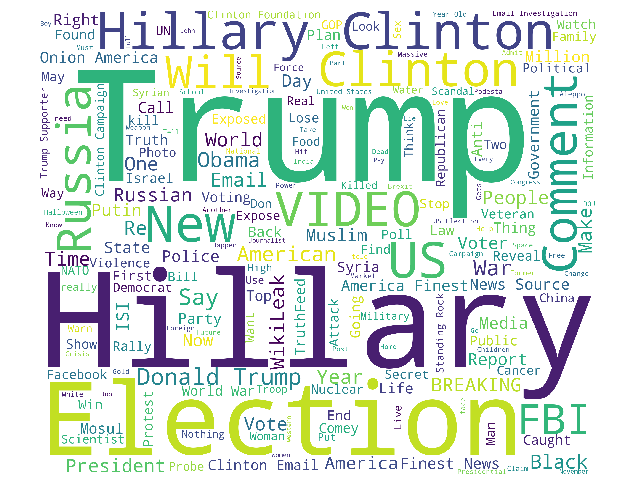

In [62]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='FAKE']

# subset all words in text based on space
words = ' '.join(df_cloud['title'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### wordcloud - Real news
Most common word used in real news titles.

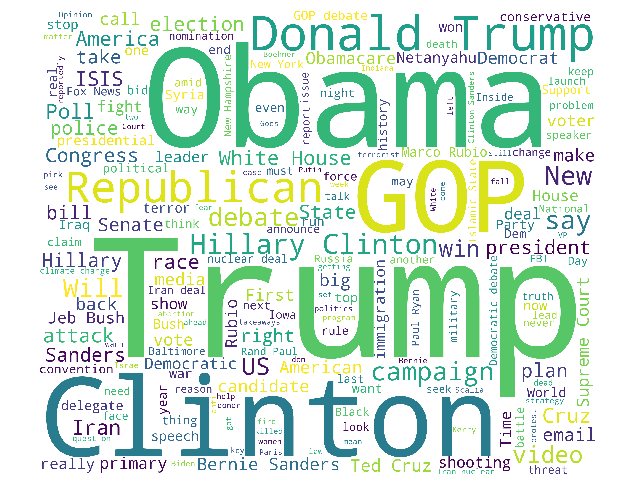

In [63]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='REAL']

# subset all words in text based on space
words = ' '.join(df_cloud['title'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### normalize text
Lets try to structure the titles and remove all unuseful elements to conduct a better analysis. Such as:
- Remove all but letters
- Tokenize words
- Convert to lowercase
- Filter stopwords
- Stem words with lemmatizer

In [51]:
# define stop words
stop_words = set(stopwords.words('english'))

# define lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# create new feature -> apply function on text
df_train['title_normalized'] = df_train.title.apply(normalizer)

# view reuslts
#df_train[['title','title_normalized', 'label']].head()

#### ngrams
As words mostly matter in context we'll look at bi, tri, quad-grams instead of just individual tokens.

In [74]:
# create new feature -> apply function on normalized_text
df_train['title_grams'] = df_train.title_normalized.apply(ngrams)

# view reuslts
#df_train[['title_grams']].head()

#### frequency count - Fake news

In [55]:
# show 20 most common words form ngrams for fake news
df_train[(df_train.label == 'FAKE')][['title_grams']].apply(count_words)['title_grams'].most_common(20)

[('hillary clinton', 51),
 ('donald trump', 31),
 ('onion america', 23),
 ('america finest', 23),
 ('finest news', 23),
 ('news source', 23),
 ('onion america finest', 23),
 ('america finest news', 23),
 ('finest news source', 23),
 ('clinton email', 18),
 ('world war', 13),
 ('clinton foundation', 13),
 ('email investigation', 12),
 ('standing rock', 11),
 ('u election', 11),
 ('hillary campaign', 9),
 ('fbi director', 8),
 ('trump supporter', 8),
 ('new york', 8),
 ('russia news', 8)]

#### frequency count - Real news

In [56]:
# show 20 most common words form ngrams for real news
df_train[(df_train.label == 'REAL')][['title_grams']].apply(count_words)['title_grams'].most_common(20)

[('donald trump', 55),
 ('hillary clinton', 37),
 ('white house', 22),
 ('supreme court', 17),
 ('bernie sander', 14),
 ('gop debate', 14),
 ('iran deal', 12),
 ('nuclear deal', 12),
 ('new hampshire', 12),
 ('fox news', 12),
 ('islamic state', 12),
 ('trump clinton', 11),
 ('ted cruz', 11),
 ('trade deal', 11),
 ('foreign policy', 11),
 ('new york', 10),
 ('presidential debate', 10),
 ('jeb bush', 9),
 ('marco rubio', 9),
 ('climate change', 9)]

#### Summary
Seems that both Hillary Clinton and Donald Trump are top represented in both real and fake news. However, Trump more so in real news and Clinton in fake news. 

*Noteworthy words for fake news:*
- onion (probably ref to satire news)
- finest 
- email (clinton scandal)

*Noteworthy words for real news:*
- deal (iran nuclear deal)
- gop
- IS

### text

In [57]:
# general overview -> 41 news articles are identicle, only 4 duplicate titels. 
# same news article reused and published with new titles
# perhaps could we
df_train.text.describe()

count     3999                                                                                                                 
unique    3839                                                                                                                 
top       Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.
freq      41                                                                                                                   
Name: text, dtype: object

#### wordcloud - Fake news
Most common word used in fake news text bodies.

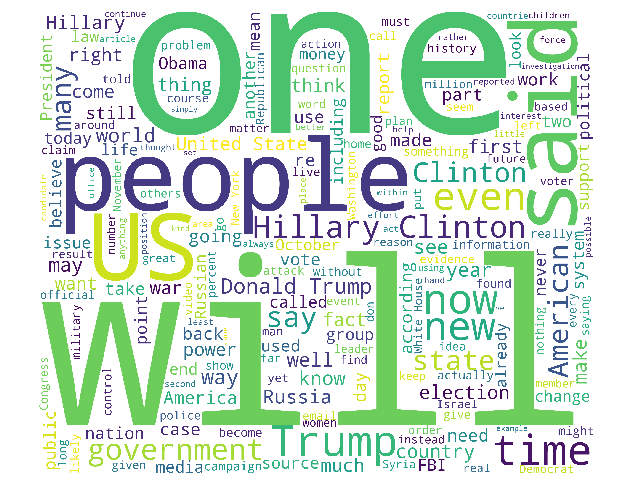

In [66]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='FAKE']

# subset all words in text based on space
words = ' '.join(df_cloud['text'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### wordcloud - Real news
Most common word used in real news text bodies.

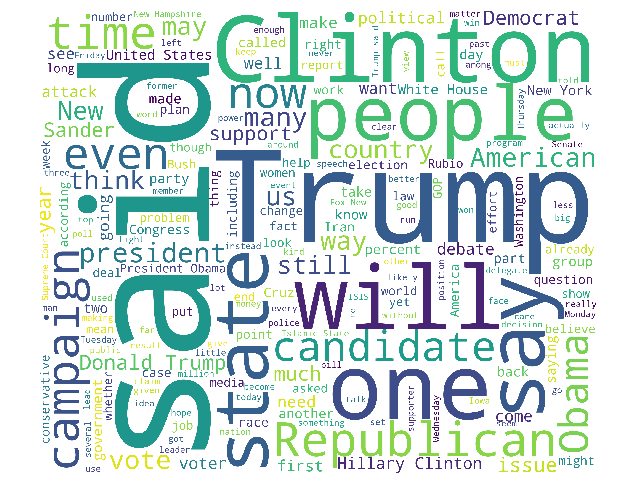

In [67]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='REAL']

# subset all words in text based on space
words = ' '.join(df_cloud['text'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### normalize text
Lets try to structure the text and remove all unuseful elements to conduct a better analysis. Such as:
- Remove all but letters
- Tokenize words
- Convert to lowercase
- Filter stopwords
- Stem words with lemmatizer

In [79]:
# define stop words
stop_words = set(stopwords.words('english'))

# define lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# create new feature -> apply function on text
df_train['text_normalized'] = df_train.text.apply(normalizer)

# view reuslts
# df_train[['text','text_normalized', 'label']].head()

,title,title_normalized,label
ID,,,
8476,You Can Smell Hillary’s Fear,"[smell, hillary, fear]",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO),"[exact, moment, paul, ryan, committed, political, suicide, trump, rally, video]",FAKE
3608,Kerry to go to Paris in gesture of sympathy,"[go, paris, gesture, sympathy]",REAL
10142,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!',"[twitter, erupt, anger, dnc, tried, warn]",FAKE
875,The Battle of New York: Why This Primary Matters,"[new, york, primary, matter]",REAL


#### ngrams
As words mostly matter in context we'll look at bi, tri, quad-grams instead of just individual tokens.

In [78]:
# create new feature -> apply function on normalized_text
df_train['text_grams'] = df_train.text_normalized.apply(ngrams)

# view reuslts
# df_train[['text_grams']].head()

,text_grams
ID,
8476,"[shillman journalism, journalism fellow, fellow freedom, freedom center, center new, new york, york writer, writer focusing, focusing radical, radical islam, islam final, final stretch, stretch election, election hillary, hillary rodham, rodham clinton, clinton gone, gone war, war fbi, fbi word, word unprecedented, unprecedented thrown, thrown around, around often, often election, election ought, ought retired, retired still, still unprecedented, unprecedented nominee, nominee major, major political, political party, party go, go war, war fbi, fbi exactly, exactly hillary, hillary people, people done, done coma, coma patient, patient waking, waking watching, watching hour, hour cnn, cnn hospital, hospital bed, bed would, would assume, assume fbi, fbi director, director james, james comey, comey hillary, hillary opponent, opponent election, election fbi, fbi attack, attack everyone, everyone obama, obama cnn, cnn hillary, hillary people, people circulated, circulated letter, letter attacking, attacking comey, comey currently, currently medium, medium hit, hit piece, piece lambasting, lambasting targeting, targeting trump, trump surprising, surprising clinton, clinton ally, ally start, start running, running attack, attack ad, ad fbi, fbi fbi, fbi leadership, leadership warned, warned entire, entire left, left wing, wing establishment, establishment form, form lynch, lynch mob, mob continue, continue going, going hillary, hillary fbi, fbi credibility, credibility attacked, attacked medium, ...]"
10294,"[digg linkedin, linkedin reddit, reddit stumbleupon, stumbleupon print, print delicious, delicious pocket, pocket tumblr, tumblr two, two fundamental, fundamental truth, truth world, world paul, paul ryan, ryan desperately, desperately want, want president, president paul, paul ryan, ryan never, never president, president today, today proved, proved particularly, particularly staggering, staggering example, example political, political cowardice, cowardice paul, paul ryan, ryan reversed, reversed course, course announced, announced back, back trump, trump train, train aboutface, aboutface week, week ago, ago previously, previously declared, declared would, would supporting, supporting defending, defending trump, trump tape, tape made, made public, public trump, trump bragged, bragged assaulting, assaulting woman, woman suddenly, suddenly ryan, ryan appearing, appearing pro, pro trump, trump rally, rally boldly, boldly declaring, declaring already, already sent, sent vote, vote make, make president, president united, united state, state surreal, surreal moment, moment figurehead, figurehead republican, republican party, party dosed, dosed gasoline, gasoline got, got stage, stage chilly, chilly afternoon, afternoon wisconsin, wisconsin lit, lit match, match speakerryan, speakerryan say, say voted, voted realdonaldtrump, realdonaldtrump republican, republican time, time come, come home, home http, http co, co vytt, vytt yvoe, yvoe pic, pic twitter, twitter com, com wcvscg, wcvscg abc, abc news, news politics, politics abcpolitics, ...]"
3608,"[secretary state, state john, john f, f kerry, kerry said, said monday, monday stop, stop paris, paris later, later week, week amid, amid criticism, criticism top, top american, american official, official attended, attended sunday, sunday unity, unity march, march terrorism, terrorism kerry, kerry said, said expects, expects arrive, arrive paris, paris thursday, thursday evening, evening head, head home, home week, week abroad, abroad said, said fly, fly france, france conclusion, conclusion series, series meeting, meeting scheduled, scheduled thursday, thursday sofia, sofia bulgaria, bulgaria plan, plan meet, meet next, next day, day foreign, foreign minister, minister laurent, laurent fabius, fabius president, president francois, francois hollande, hollande return, return washington, washington visit, visit kerry, kerry family, family childhood, childhood tie, tie countr

#### frequency count - Fake news

In [70]:
# show 20 most common words form ngrams for fake news
df_train[(df_train.label == 'FAKE')][['text_grams']].apply(count_words)['text_grams'].most_common(20)

[('hillary clinton', 1469),
 ('donald trump', 1117),
 ('united state', 833),
 ('new york', 444),
 ('white house', 426),
 ('clinton campaign', 326),
 ('year old', 274),
 ('bill clinton', 259),
 ('presidential election', 245),
 ('clinton foundation', 237),
 ('american people', 234),
 ('secretary state', 233),
 ('wall street', 228),
 ('brain force', 210),
 ('http www', 202),
 ('year ago', 196),
 ('foreign policy', 189),
 ('http www com', 181),
 ('democratic party', 178),
 ('law enforcement', 176)]

#### frequency count - Real news

In [71]:
# show 20 most common words form ngrams for real news
df_train[(df_train.label == 'REAL')][['text_grams']].apply(count_words)['text_grams'].most_common(20)

[('donald trump', 1184),
 ('hillary clinton', 1118),
 ('united state', 1049),
 ('white house', 1022),
 ('new york', 987),
 ('fox news', 648),
 ('new hampshire', 634),
 ('president obama', 611),
 ('trump said', 497),
 ('islamic state', 494),
 ('secretary state', 467),
 ('supreme court', 465),
 ('ted cruz', 442),
 ('barack obama', 424),
 ('last week', 424),
 ('bernie sander', 419),
 ('foreign policy', 404),
 ('presidential candidate', 396),
 ('republican party', 394),
 ('south carolina', 353)]

#### Summary
Following the same break down as for titles but for our article text, we find the same results as for titles. 

*Noteworthy words for fake news:*
- wall street
- bill clinton
- year old

*Noteworthy words for real news:*
- fox news
- president obama
- new hampshire

In [41]:
df_train.columns

Index(['title', 'text', 'label', 'X1', 'X2'], dtype='object')

### NaN Imputation

#### X1
Impute NaNs as unknown 